<a href="https://colab.research.google.com/github/andyrids/trackinsight/blob/main/trackinsight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install haversine mapclassify folium -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 860.4 kB/s eta 0:00:00


In [19]:
import concurrent.futures
import functools
import io
import multiprocessing
import pathlib
import zipfile

from typing import Iterable

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from geopandas import GeoDataFrame
from haversine import haversine_vector, Unit
from numpy.typing import ArrayLike, NDArray
from pandas import DataFrame, DatetimeIndex
from scipy.interpolate import pchip_interpolate
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
# sort array
# a = a[a[:, 0].argsort()]

In [ ]:
# [[t, x, y], ...]
# np.split(a[:,1], np.unique(a[:, 0], return_index=True)[1][1:])

In [3]:
def sort_trajectories(
        data: DataFrame,
        uid_column: str = "ti_uid",
        time_column: str = "ti_timestamp"
    ) -> DataFrame:
    """Sort trajectories by unique identifier & timestamp."""
    return data.sort_values(by=[uid_column, time_column]).reset_index(drop=True)

In [4]:
def assign_epoch_time(data: DataFrame, time_column: str = "ti_timestamp") -> DataFrame:
    """"""
    return data.assign(
        ti_timestamp=DatetimeIndex(data[time_column]).asi8 // 10**9
    )

In [5]:
def assign_elapsed_seconds(
        data: DataFrame,
        time_column: str = "ti_timestamp"
    ) -> DataFrame:
    """Calculate elapsed seconds between trajectory points.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        time_column (str): Timestamp column.

    Returns:
        A DataFrame with a `ti_elapsed_time_s` column containing
        the elapsed time between trajectory points in seconds.
    """
    elapsed_time_s = data[time_column].diff()
    return data.assign(ti_elapsed_time_s=elapsed_time_s)

In [6]:
def assign_elapsed_distance(
        data: DataFrame,
        latitude_column: str = "ti_latitude",
        longitude_column: str = "ti_longitude"
    ) -> DataFrame:
    """Calculate the distance travelled between trajectory points.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        x_column (str): X-coordinate column.
        y_column (str): Y-coordinate column.

    Returns:
        A DataFrame with a `ti_distance_m` column, containing the
        distance travelled between trajectory points in meters.
    """
    latlong_columns = [latitude_column, longitude_column]
    distance_m = haversine_vector(
        data[latlong_columns], data[latlong_columns].shift(), Unit.METERS, check=False
    )

    return data.assign(ti_distance_m=distance_m)

In [7]:
def assign_calculated_speed(
    data: DataFrame,
    elapsed_time_column: str = "ti_elapsed_time_s",
    elapsed_distance_column: str = "ti_distance_m"
) -> DataFrame:
    """Calculate the speed between trajectory points.

    NOTE: Speeds are calculated in m/s & Kn.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        elapsed_time_column (str): Elapsed time column.
        elapsed_distance_column (str): Elapsed distance column.

    Returns:
       A DataFrame with `ti_speed_mps` & `ti_speed_kts`
       speed columns.
    """
    speed_mps = data[elapsed_distance_column] / data[elapsed_time_column]
    speed_kts = speed_mps * 1.943844
    return data.assign(ti_speed_mps=speed_mps, ti_speed_kts=speed_kts)

In [8]:
def convert_to_geodataframe(
        data: DataFrame,
        latitude_column: str = "ti_latitude",
        longitude_column: str = "ti_longitude",
        crs: str = "EPSG:4326"
    ) -> GeoDataFrame:
    """Convert trajectory data to a GeoDataFrame.

        Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        latitude_column (str): Latitude column.
        longitude_column (str): Longitude column.

    Returns:
        A GeoDataFrame.
    """
    geometry = gpd.points_from_xy(data[longitude_column], data[latitude_column], crs=crs)
    geometry_3857 = geometry.to_crs(epsg=3857)
    data = data.assign(geometry=geometry, geometry_3857=geometry_3857)
    return GeoDataFrame(data, geometry="geometry")

In [9]:
def transform_trajectories(
    data: DataFrame,
    uid_column: str,
    datetime_column: str,
    latitude_column: str,
    longitude_column: str,
) -> DataFrame:
    """Transform AIS trajectory data.

    Args:
        data (DataFrame): Trajectory data.
        uid_column (str): Unique identifier column.
        datetime_column (str): Datetime64 column.
        latitude_column (str): Latitude column.
        longitude_column (str): Longitude column.

    Returns:
        A DataFrame with transformed trajectory data.
    """
    if data[datetime_column].dtype.name.startswith("datetime64"):
        data = data.pipe(assign_epoch_time, datetime_column)
        timestamp_column = "ti_timestamp"
    else:
        raise ValueError(f"Unsupported time column type: {data[datetime_column].dtype}")

    columns = (uid_column, datetime_column, timestamp_column, latitude_column, longitude_column)
    data = data.filter(columns)

    ti_columns = ("ti_uid", "ti_datetime", "ti_timestamp", "ti_latitude", "ti_longitude")
    data = data.set_axis(ti_columns, axis="columns")

    grouped = data.groupby("ti_uid", as_index=False, group_keys=False)
    data = grouped[data.columns].apply(lambda x:
        x
        .pipe(sort_trajectories)
        .pipe(assign_elapsed_seconds)
        .pipe(assign_elapsed_distance)
        .pipe(assign_calculated_speed)
    )

    return data

In [10]:
r = requests.get("https://figshare.com/ndownloader/files/16442771")

In [11]:
zf = zipfile.ZipFile(io.BytesIO(r.content))

In [12]:
zf.extractall(path="data")

In [13]:
def read_csv_files(path: pathlib.Path) -> DataFrame:
    data = pd.read_csv(path, sep=";")
    return data.assign(uid=path.stem)


def process_file(path: pathlib.Path) -> DataFrame | None:
    try:
        return read_csv_files(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

In [14]:
num_processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=num_processes) as pool:
    paths = tuple(pathlib.Path("data/data").glob("*.txt"))
    results = pool.map(process_file, paths[:100])

dataframes = filter(lambda x: isinstance(x, DataFrame), results)

In [15]:
data = (
    pd.concat(dataframes)
    .assign(t=lambda x: pd.to_timedelta(x["t"], unit="s"))
    .assign(datetime=lambda x: pd.to_datetime("now") + x["t"])
    .filter(("uid", "x", "y", "datetime"), axis="columns")
)

*   **x** is the longitude (in degrees)

*   **y** is the latitude (in degrees)

*   **vx** is the x-velocity (in knots) given in the AIS message (not computed from positions and time)

*   **vy** is the y-velocity (in knots) given in the AIS message (not computed from positions and time)

*   **t** the time since the beginning of the trajectory (in seconds).

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30846 entries, 0 to 126
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   uid       30846 non-null  object        
 1   x         30846 non-null  float64       
 2   y         30846 non-null  float64       
 3   datetime  30846 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.2+ MB


In [17]:
ti_data = transform_trajectories(data, "uid", "datetime", "y", "x")
ti_data

,ti_uid,ti_datetime,ti_timestamp,ti_latitude,ti_longitude,ti_elapsed_time_s,ti_distance_m,ti_speed_mps,ti_speed_kts
0,traj_10079,2025-02-18 18:58:29.202819,1739905109,48.962542,-6.094487,NaN,NaN,NaN,NaN
0,traj_10102,2025-02-18 18:58:29.202819,1739905109,48.473423,-5.818003,NaN,NaN,NaN,NaN
0,traj_10246,2025-02-18 18:58:29.202819,1739905109,49.687537,-3.651203,NaN,NaN,NaN,NaN
0,traj_10490,2025-02-18 18:58:29.202819,1739905109,45.972363,-7.741768,NaN,NaN,NaN,NaN
0,traj_10838,2025-02-18 18:58:29.202819,1739905109,48.478177,-5.815512,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2499,traj_4064,2025-02-23 15:52:38.202819,1740325958,48.888342,-5.618222,181.0,245.389758,1.355745,2.635356
2500,traj_4064,2025-02-23 15:54:39.202819,1740326079,48.887847,-5.615925,121.0,176.710005,1.460413,2.838816
2501,traj_4064,2025-02-23 15:56:57.202819,1740326217,48.887610,-5.613290,138.0,194.446628,1.409034,2.738941
2502,traj_4064,2025-02-23 15:59:24.202819,1740326364,48.887673,-5.610163,147.0,228.714570,1.555881,3.024391


In [38]:
gdf_ti_data = convert_to_geodataframe(ti_data.query("ti_uid.isin(['traj_10079'])"))
gdf_ti_data = gdf_ti_data.assign(buffer=lambda x: x["geometry_3857"].buffer(2000, cap_style="square").to_crs(4326))
gdf_ti_data

,ti_uid,ti_datetime,ti_timestamp,ti_latitude,ti_longitude,ti_elapsed_time_s,ti_distance_m,ti_speed_mps,ti_speed_kts,geometry,geometry_3857,buffer
0,traj_10079,2025-02-18 18:58:29.202819,1739905109,48.962542,-6.094487,NaN,NaN,NaN,NaN,POINT (-6.09449 48.96254),POINT (-678435.152 6268507.887),"POLYGON ((-6.07652 48.97434, -6.07652 48.95074..."
1,traj_10079,2025-02-18 18:58:40.202819,1739905120,48.962368,-6.094998,11.0,42.033767,3.821252,7.427917,POINT (-6.095 48.96237),POINT (-678492.111 6268478.498),"POLYGON ((-6.07703 48.97416, -6.07703 48.95057..."
2,traj_10079,2025-02-18 19:09:18.202819,1739905758,48.951167,-6.127578,638.0,2685.161221,4.208717,8.181089,POINT (-6.12758 48.95117),POINT (-682118.9 6266579.457),"POLYGON ((-6.10961 48.96296, -6.10961 48.93937..."
3,traj_10079,2025-02-18 19:09:30.202819,1739905770,48.950968,-6.128242,12.0,53.222266,4.435189,8.621315,POINT (-6.12824 48.95097),POINT (-682192.742 6266545.837),"POLYGON ((-6.11028 48.96277, -6.11028 48.93917..."
4,traj_10079,2025-02-18 19:11:08.202819,1739905868,48.949245,-6.133515,98.0,430.122588,4.389006,8.531543,POINT (-6.13352 48.94924),POINT (-682779.767 6266253.716),"POLYGON ((-6.11555 48.96104, -6.11555 48.93744..."
5,traj_10079,2025-02-18 19:11:18.202819,1739905878,48.949093,-6.134038,10.0,41.772086,4.177209,8.119842,POINT (-6.13404 48.94909),POINT (-682838.024 6266228.008),"POLYGON ((-6.11607 48.96089, -6.11607 48.93729..."
6,traj_10079,2025-02-18 19:11:27.202819,1739905887,48.948930,-6.134553,9.0,41.763774,4.640419,9.020251,POINT (-6.13455 48.94893),POINT (-682895.353 6266200.322),"POLYGON ((-6.11659 48.96073, -6.11659 48.93713..."
7,traj_10079,2025-02-18 19:11:35.202819,1739905895,48.949093,-6.134038,8.0,41.763774,5.220472,10.147783,POINT (-6.13404 48.94909),POINT (-682838.024 6266228.008),"POLYGON ((-6.11607 48.96089, -6.11607 48.93729..."
8,traj_10079,2025-02-18 19:12:01.202819,1739905921,48.948372,-6.136058,26.0,167.925845,6.458686,12.554679,POINT (-6.13606 48.94837),POINT (-683062.889 6266105.682),"POLYGON ((-6.11809 48.96017, -6.11809 48.93657..."
9,traj_10079,2025-02-18 19:12:18.202819,1739905938,48.947995,-6.137047,17.0,83.446832,4.908637,9.541625,POINT (-6.13705 48.948),POINT (-683172.91 6266041.836),"POLYGON ((-6.11908 48.95979, -6.11908 48.93619..."


In [39]:
style = """
background-color: white;
font-size: 18px;
font-family: Arial;
border: 2px solid black;
border-radius: 5px;
padding: 10px;
"""

gdf_ti_data.explore(
    "ti_uid",
    tiles="CartoDB dark_matter",
    popup=True,
    popup_kwds={"style": style},
    tooltip_kwds={"style": style},
)

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPoint, MultiPolygon
from shapely.ops import cascaded_union
from shapely import concave_hull

def concave_hull_segmentation(gdf, time_column='ti_datetime', buffer_column='buffer', uid_column='ti_uid'):
    # Ensure the time column is datetime
    gdf[time_column] = pd.to_datetime(gdf[time_column])

    # Group by hour and UID
    hourly_segments = gdf.groupby([pd.Grouper(key=time_column, freq='1h'), uid_column])

    concave_hulls = []
    for (hour, uid), group in hourly_segments:
        # Handle cases where there are no points in an hour
        if group.empty:
            continue

        # Combine buffered geometries within the hourly segment
        # combined_buffer = cascaded_union(group[buffer_column])

        combined_buffer = concave_hull(MultiPolygon(group[buffer_column].to_list()), ratio=0.9, allow_holes=False)

        # If the combined buffer is not a Polygon, skip
        if not isinstance(combined_buffer, Polygon):
            continue

        concave_hulls.append({
            'hour': hour,
            "min_time": f"{group['ti_datetime'].min():%H:%M:%S}",
            "max_time": f"{group['ti_datetime'].max():%H:%M:%S}",
            'uid': uid,
            'geometry': combined_buffer,
            'n_points': len(group)
        })

    return gpd.GeoDataFrame(concave_hulls, geometry='geometry', crs=gdf.crs)


In [23]:
# Example usage (assuming your GeoDataFrame is named gdf_ti_data):
concave_hulls_gdf = concave_hull_segmentation(gdf_ti_data)
print(concave_hulls_gdf.head())

# Plot the concave hulls (optional)
m = concave_hulls_gdf.explore("uid", tiles="CartoDB dark_matter")

gdf_ti_data.explore(
    "ti_uid",
    popup=True,
    popup_kwds={"style": style},
    tooltip_kwds={"style": style},
    marker_kwds={"radius": 5, "color": "black"},
    m=m
)
#

NameError: name 'concave_hull_segmentation' is not defined

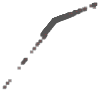

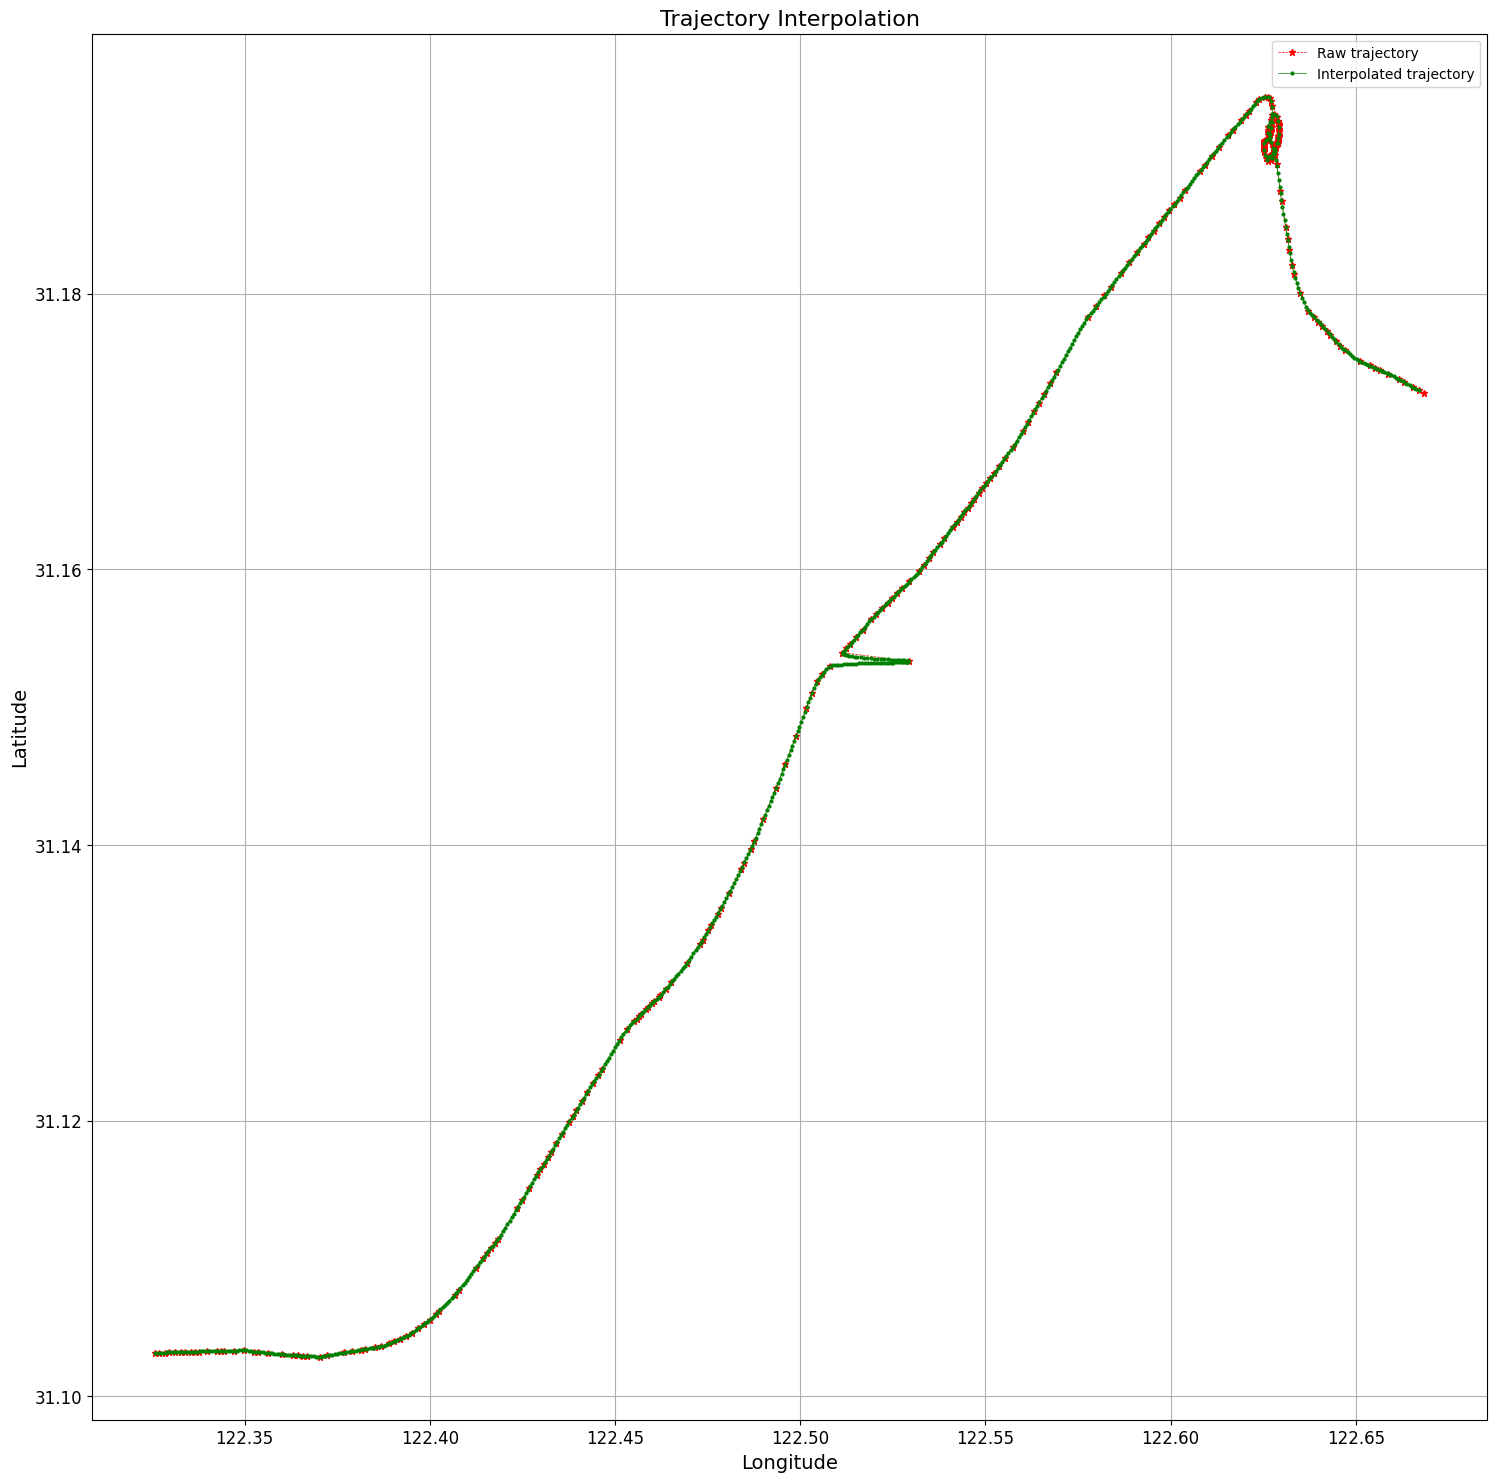

<Figure size 1800x1800 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,18), dpi=100)

plt.plot(
    ti_data['ti_longitude'],
    ti_data['ti_latitude'],
    marker='*',
    ms=5,
    linestyle='--',
    color='red',
    linewidth=0.5,
    label='Raw trajectory'
)

plt.plot(
    y[:,1],
    y[:,0],
    marker='o',
    ms=2,
    linestyle='-',
    color='g',
    linewidth=0.5,
    label='Interpolated trajectory'
)

plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('Longitude', fontdict={'size': 14})
plt.ylabel('Latitude', fontdict={'size': 14})
plt.title('Trajectory Interpolation', fontdict={'size': 16})
plt.ticklabel_format(useOffset=False, style='plain')
plt.grid()
plt.legend()
plt.figure(figsize=(18,18), dpi=100)
plt.tight_layout()
plt.show()

In [ ]:
linestring = shapely.LineString(geo_data_transformed.geometry)

In [ ]:
# extracts the coordinates of all points in the linestrings and their corresponding linestring index
geom, index = shapely.get_coordinates(linestring, return_index=True)

In [ ]:
# trajectory points belowng to one segment Linestring (one index value)
index

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
geom.shape, geom[:-1, 0].shape

((308, 2), (307,))

In [ ]:
# creates a mask to handle cases where line segments might overlap
no_mix_mask = index[:-1] == index[1:]
no_mix_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
geo_data_transformed["ti_distance_m"].dropna()

ti_uid        
244726000  1      125.782026
           2      152.797062
           3      239.780926
           4      119.465403
           5      280.533425
                     ...    
           303    149.160800
           304    157.930635
           305    101.720586
           306    153.617611
           307     97.113893
Name: ti_distance_m, Length: 307, dtype: float64

In [ ]:
%timeit geo_data_transformed["ti_distance_m"].sum()

32.5 µs ± 4.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
distances = geo_data_transformed["ti_distance_m"].dropna().to_numpy()
%timeit np.bincount((index[:-1])[no_mix_mask], weights=distances[no_mix_mask])

4.39 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
import collections
import time
# import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
# from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score

In [73]:
# prompt: The cell below is the MiPo (Middle Polar Coordinates) method of finding outlier trajectories. I would like to take an individual time-sorted trajectory latitude and longitude values in decimal degrees and iterate over the trajectory points in a sliding window of size n and create the fixed-length mipo feature vectors and pass this to local outlier factors in order to identify erroneous trajectory points

import numpy as np
from sklearn.neighbors import LocalOutlierFactor

def mipo_outlier_detection(trajectory, window_size, n_neighbors=20):
    """
    Identifies outlier points in a trajectory using the MiPo method and LOF.

    Args:
        trajectory (np.ndarray): A NumPy array of shape (N, 2) representing the trajectory,
                                 where N is the number of points and each point is [latitude, longitude].
        window_size (int): The size of the sliding window.
        n_neighbors (int): The number of neighbors to consider for LOF.

    Returns:
        np.ndarray: An array of outlier scores for each point in the trajectory.
    """

    num_points = len(trajectory)
    mipo_features = []
    outlier_labels = np.zeros(num_points)
    outlier_scores = np.zeros(num_points)

    for i in range(num_points - window_size + 1):
        window = trajectory[i:i + window_size]
        # Calculate MiPo features for the current window (example features)
        # Replace this with your actual MiPo feature calculation.
        # These are just placeholder features.
        centroid = np.mean(window, axis=0)
        distances_to_centroid = np.linalg.norm(window - centroid, axis=1)
        mean_distance = np.mean(distances_to_centroid)
        std_distance = np.std(distances_to_centroid)

        mipo_features.append([mean_distance, std_distance])  # Example MiPo features

    if len(mipo_features) > 0 :
        # Apply Local Outlier Factor (LOF)
        clf = LocalOutlierFactor(n_neighbors=min(n_neighbors, len(mipo_features) -1), contamination='auto') # Adjusted n_neighbors
        start_index = window_size // 2
        end_index = num_points - (window_size - window_size // 2) + 1  # Adjusted for even/odd
        outlier_labels[start_index : end_index] = clf.fit_predict(mipo_features)
        outlier_scores[start_index : end_index] = -clf.negative_outlier_factor_

    return outlier_labels, outlier_scores

# Example usage (assuming 'trajectory_data' is your trajectory data as a NumPy array)
# Replace with your actual trajectory data
# Example trajectory data (replace with your data)
trajectory_data = gdf_ti_data[['ti_latitude', 'ti_longitude']].to_numpy()

window_size = 20 #Example Window Size
outlier_labels, outlier_scores = mipo_outlier_detection(trajectory_data, window_size)

# Analyze the outlier_scores
print(outlier_scores)

# Example: Identify outlier points (outlier score < -0.5)
outlier_indices = np.where(outlier_scores < -0.5)[0]
print("Outlier indices:", outlier_indices)

gdf_ti_data.assign(
    ti_mipo_outlier=outlier_labels < -0.5,
    ti_mipo_score=outlier_scores
    ).explore(
    "ti_mipo_outlier",
    tiles="CartoDB dark_matter",
    popup=True,
    popup_kwds={"style": style},
    tooltip_kwds={"style": style},
    marker_kwds={"radius": 5}
)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.99988548 0.99864562
 0.99695215 0.99767333 0.99787941 0.99773708 0.99958694 1.00208076
 1.00348313 1.00370583 1.00271805 1.00130915 0.99982178 0.99743732
 0.99603141 0.99248701 0.99116819 0.98980711 0.98980711 0.98980711
 1.01858651 1.35400534 1.64215042 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Outlier indices: []


In [ ]:
def loadData(path):
    with open(path, 'r') as f:
        routes = f.readlines()
    return routes


def findSourceDestination(routes):
    X = []
    for i in range(len(routes)):
        route = np.array(eval(routes[i]))
        X.append(route[0])
        X.append(route[-1])
    X = np.array(X)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    res = kmeans.cluster_centers_
    return res


def sortPointsFromS2D(route, res):
    # res[0] is the S point
    if sum((res[0] - route[0]) ** 2) <= sum((res[1] - route[0]) ** 2):
        return route
    else:
        return route[::-1]


def positionOfLine(A, B, C):
    Ax, Ay, Bx, By, X, Y = A[0], A[1], B[0], B[1], C[0], C[1]
    position = np.sign((Bx - Ax) * (Y - Ay) - (By - Ay) * (X - Ax))
    if position >= 0:
        return 1
    else:
        return -1


def calAngle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    # cal the angle between side ab and bc
    ba = a - b
    bc = c - b

    t1 = np.dot(ba, bc)
    t2 = np.linalg.norm(ba)
    t3 = np.linalg.norm(bc)

    if np.isnan(t1) or np.isnan(t2) or (t2 * t3) == 0:
        return 0
    if np.isnan(t3):
        return 180

    else:
        cosine_angle = t1 / (t2 * t3)
        if cosine_angle > 1:
            cosine_angle = 1
        if cosine_angle < -1:
            cosine_angle = -1
        angle = np.arccos(cosine_angle)
        p = positionOfLine(a, b, c)
        if p == 1:
            return angle * 180 / np.pi
        else:
            return 360 - angle * 180 / np.pi


def extractFearureMiPo(route, res, k):
    # route is a trajectory
    # res=[S,D], S and D is the scource and destination point,respectively.
    # k for the number of bins

    if k <= 0:
        return "error: k should be more than 0"

    # cal angles
    S, M, D = res[0], sum(res) / 2, res[1]

    # distribute points into bucket
    bin_angle_range = 180 / k  # correct

    feature_ponit = [0, 0]
    bucket = {i: [] for i in range(k)}
    bucket_dist = {i: 0 for i in range(k)}

    bucket[0].append(0)
    for i in range(1, len(route) - 1):
        angles = calAngle(S, M, route[i])
        angles_bin = 0
        if angles <= 180:
            angles_bin = angles // bin_angle_range
            feature_ponit[0] += 1
        else:
            angles_bin = (360 - angles) // bin_angle_range
            feature_ponit[1] += 1
        idx = int(angles_bin)
        if idx > k - 1:
            idx = k - 1
        bucket[idx].append(i)
        bucket_dist[idx] += np.sqrt(np.sum((route[i] - M) ** 2))  # distance fearure
    bucket[k - 1].append(-1)

    # distance feature
    feature_dist = []
    for j in range(len(bucket)):
        avg_dst = 0
        a = len(bucket[j])
        if a > 0:
            avg_dst = bucket_dist[j] / a
        else:
            if len(feature_dist) > 0:
                avg_dst = feature_dist[-1]
            else:
                avg_dst = np.sqrt(np.sum((S - M) ** 2))
        feature_dist.append(avg_dst)

    feature = feature_dist + feature_ponit
    return feature

In [ ]:
str(pathlib.Path("dataset/") / "AiSq5D" / "inners.txt")

'dataset/AiSq5D/inners.txt'

In [ ]:
r_inner.request.path_url

'/timeisafriend/trajectory_mipo/main/main/dataset/AiSq5D/inners.txt'

In [ ]:
for f in ["AiSq5D","AiSq10D","AiSq5P","AiSq10P","AiSq5DP","AiSq10DP","StSt5M","StSt10M","StSt5R","StSt10R","UnCh5M","UnCh10M"]:

    path_inner = pathlib.Path("dataset/") / f / "inners.txt"
    path_outlier = pathlib.Path("dataset/") / f / "outliers.txt"

    path_inner.parent.mkdir(exist_ok=True, parents=True)
    path_outlier.parent.mkdir(exist_ok=True, parents=True)

    repository = "https://raw.githubusercontent.com/timeisafriend/trajectory_mipo/"
    r_inner = requests.get(f"{repository}/main/{path_inner}")
    r_outlier = requests.get(f"{repository}/main/{path_outlier}")

    path_inner.write_text(r_inner.text)
    path_outlier.write_text(r_outlier.text)

    outliers = loadData(path_outlier)
    inners = loadData(path_inner)

    label = [1] * len(outliers) + [0] * len(inners)
    data = outliers + inners
    print('dataset####', f, len(data))

    # find S-D
    SD_points = findSourceDestination(data)

    time_e0 = time.time()

    # MiPo for feature extraction
    k = 50  # for bins
    features = []
    for i in range(len(data)):
        p1_resorted = np.array(eval(data[i]))
        p1_resorted = np.concatenate((np.array([SD_points[0]]), p1_resorted, np.array([SD_points[-1]])), axis=0)
        feature = extractFearureMiPo(p1_resorted, SD_points, k)
        features.append(feature)
#     time_e1 = time.time()
#     print(time_e1 - time_e0)  # time for feature

    # min-max scaling
    features = np.array(features)
    features = (np.array(features) - np.min(features, axis=0)) / (np.max(features, axis=0) + 0.0001)

    # LOF detector
    n_neighbors = 15  # for LOF
    clf = LocalOutlierFactor(n_neighbors)
    OutlierScore = -clf.fit_predict(features)
#     time_e2 = time.time()
#     print(time_e2 - time_e1)  # time for LOF

    roc = roc_auc_score(label, OutlierScore)
    print('auc', roc)

dataset#### AiSq5D 1115
auc 0.9670668953687821
dataset#### AiSq10D 1115
auc 0.8303126335279873
dataset#### AiSq5P 1115
auc 0.8683899905571293
dataset#### AiSq10P 1115
auc 0.9109699600561768
dataset#### AiSq5DP 1115
auc 0.9379299878591664
dataset#### AiSq10DP 1115
auc 0.9354837273892608
dataset#### StSt5M 192
auc 0.7362637362637362
dataset#### StSt10M 202
auc 0.6697802197802197
dataset#### StSt5R 191
auc 0.7448107448107448
dataset#### StSt10R 200
auc 0.6587301587301587
dataset#### UnCh5M 763
auc 0.5893466424682395
dataset#### UnCh10M 806
auc 0.6282503192848021


In [ ]:
p1_resorted

array([[ 97581.20287336, -13908.52888101],
       [ 97581.31092456, -13913.45362703],
       [ 97583.53150852, -13910.42120866],
       [ 97620.90299068, -13886.89979623],
       [ 97666.45643242, -13855.26134317],
       [ 97673.52508877, -13764.08609918],
       [ 97679.82653429, -13671.92025688],
       [ 97558.56829429, -13678.55092304],
       [ 97451.06159663, -13699.00782886],
       [ 97418.08665441, -13600.36183345],
       [ 97479.4408558 , -13510.46182328],
       [ 97480.37217627, -13467.41138182],
       [ 97539.67819025, -13393.55238901],
       [ 97590.79070485, -13270.75947563],
       [ 97603.28160422, -13190.52131316],
       [ 97601.58479898, -13210.71447103]])

## MiPo (Middle Polar Coordinates)

MiPo methodology offers an elegant solution by transforming variable-length trajectory data into fixed-length tabular features that can then be analyzed using standard outlier detection algorithms.

The core idea behind MiPo consists of these key steps:

1. Reference Point Calculation for a set of trajectories with the same start point S and end point D, MiPo first calculates a reference point M as the midpoint between S and D:

```python
# S and D contain (lat, lon) coordinates
M = (S + D) / 2  
```

2. Polar Coordinate Transformation for each point P in a trajectory, MiPo converts its Cartesian coordinates (latitude, longitude) into polar coordinates relative to point M:

    * *θ* - The angle between vector MS (reference vector) and vector MP
    * *d* - The Euclidean distance between point P and point M

3. Binning and Feature Extraction

    * Distance Features
        * Divides the 360° range around M into k equal angular bins
        * For each bin, calculates the mean distance of all points falling within that bin's angular range
        * This captures the spatial distribution of points relative to the middle point

    * Point Features
        * Counts the number of trajectory points falling on either side of line SD
        * Specifically counts points in [0, π) and [π, 2π] ranges
        * This captures the basic shape characteristics of the trajectory

4. Feature Vector Creation, the final feature vector for each trajectory combines both types:


```python
F = [distance_features, point_features]
# distance_features: mean distances for each angular bin
# point_features: point counts for left/right of SD line
```

The key advantages of MiPo include:

1. Transforms variable-length trajectories into fixed-length feature vectors
2. Preserves important spatial relationships and distribution characteristics
3. Enables use of standard outlier detection algorithms like LOF
4. Linear time complexity
5. Robust to different sampling rates and speeds

In [ ]:
def calculate_mipo_features(
        data: DataFrame,
        latitude_column: str = "ti_latitude",
        longitude_column: str = "ti_longitude",
        k_bins=30
    ):

    coordinates = data[[latitude_column, longitude_column]].to_numpy()

    # Get start and end points
    source, *_, destination = coordinates

    # Calculate middle point
    middle = (source + destination) / 2

    # convert to polar coordinates relative to middle
    angles = np.arctan2(coordinates[:,0] - middle[0], coordinates[:,1] - middle[1])
    distances = np.sqrt(np.sum((coordinates - middle)**2, axis=1))

    # Calculate distance features
    bins = np.linspace(0, 2*np.pi, k_bins+1)
    distance_features = []
    for i in range(k_bins):
        mask = (angles >= bins[i]) & (angles < bins[i+1])
        bin_distances = distances[mask]
        mean_distance = np.mean(bin_distances) if len(bin_distances) > 0 else 0
        distance_features.append(mean_distance)

    # Calculate point features
    left_points = np.sum(angles < np.pi)
    right_points = len(angles) - left_points
    point_features = [left_points, right_points]

    return np.concatenate([distance_features, point_features])

In [ ]:
def mipo_outliers(
        data: DataFrame,
        latitude_column: str = "ti_latitude",
        longitude_column: str = "ti_longitude",
        k_bins=30
    ):

    coordinates = data[[latitude_column, longitude_column]].to_numpy()

    # Get start and end points
    source, *_, destination = coordinates

    # Calculate middle point
    middle = (source + destination) / 2

    # convert to polar coordinates relative to middle
    angles = np.arctan2(coordinates[:,0] - middle[0], coordinates[:,1] - middle[1])
    distances = np.sqrt(np.sum((coordinates - middle)**2, axis=1))
    # Create feature vector for each point
    # We'll use both polar coordinates and additional geometric features
    features = []
    for i in range(len(coordinates)):
        point_features = [
            angles[i],                    # Angle from reference vector
            distances[i],                 # Distance from middle point
            distances[i] / np.mean(distances),  # Relative distance (normalized)
            angles[i] - np.mean(angles),  # Angular deviation from mean
        ]
        features.append(point_features)

    features = np.array(features)

    # Need at least 4 points for meaningful LOF analysis
    if len(features) < 4:
        raise ValueError("Need at least 4 points in trajectory for outlier detection")

    # Use LOF to detect outliers among points
    n_neighbors = min(3, len(features) - 1)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)

    labels = lof.fit_predict(features)
    scores = -lof.negative_outlier_factor_

    return labels, scores

This implementation will convert each GPS trajectory into a feature vector that can then be passed to outlier detection algorithms. The number of bins (k) is a parameter that can be tuned based on your specific needs - the paper suggests using half the average trajectory length as a starting point.
The resulting feature vectors can be used with standard outlier detection algorithms like LOF (Local Outlier Factor):

In [ ]:
gdf_ti_data["ti_uid"].value_counts()

,count
ti_uid,
traj_1065,1133
traj_104,209
traj_10184,68
traj_10180,56
traj_1044,53


In [ ]:
gdf_ti_data.query("ti_uid == 'traj_1065'")

,ti_uid,ti_datetime,ti_timestamp,ti_latitude,ti_longitude,ti_elapsed_time_s,ti_distance_m,ti_speed_mps,ti_speed_kts,geometry,geometry_3857,buffer
0,traj_1065,2025-02-17 21:33:02.415095,1739827982,48.266307,-6.099437,NaN,NaN,NaN,NaN,POINT (-6.09944 48.26631),POINT (-678986.184 6151273.68),"POLYGON ((-6.08147 48.27826, -6.08147 48.25435..."
1,traj_1065,2025-02-17 21:33:54.415095,1739828034,48.271143,-6.095233,52.0,621.316631,11.948397,23.225819,POINT (-6.09523 48.27114),POINT (-678518.271 6152082.552),"POLYGON ((-6.07727 48.2831, -6.07727 48.25918,..."
2,traj_1065,2025-02-17 21:34:37.415095,1739828077,48.275242,-6.091660,43.0,526.891372,12.253288,23.818480,POINT (-6.09166 48.27524),POINT (-678120.489 6152768.006),"POLYGON ((-6.07369 48.2872, -6.07369 48.26328,..."
3,traj_1065,2025-02-17 21:34:51.415095,1739828091,48.276535,-6.090540,14.0,165.988109,11.856293,23.046785,POINT (-6.09054 48.27654),POINT (-677995.811 6152984.33),"POLYGON ((-6.07257 48.28849, -6.07257 48.26458..."
4,traj_1065,2025-02-17 21:35:01.415095,1739828101,48.277472,-6.089718,10.0,120.603487,12.060349,23.443437,POINT (-6.08972 48.27747),POINT (-677904.344 6153141.001),"POLYGON ((-6.07175 48.28943, -6.07175 48.26551..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1128,traj_1065,2025-02-18 00:10:51.415095,1739837451,49.016677,-5.100650,7.0,24.536246,3.505178,6.813519,POINT (-5.10065 49.01668),POINT (-567801.761 6277691.549),"POLYGON ((-5.08268 49.02846, -5.08268 49.00489..."
1129,traj_1065,2025-02-18 00:11:16.415095,1739837476,49.018095,-5.096855,25.0,318.533970,12.741359,24.767214,POINT (-5.09686 49.0181),POINT (-567379.303 6277932.295),"POLYGON ((-5.07889 49.02988, -5.07889 49.00631..."
1130,traj_1065,2025-02-18 00:11:26.415095,1739837486,49.018313,-5.096275,10.0,48.768227,4.876823,9.479782,POINT (-5.09628 49.01831),POINT (-567314.738 6277969.355),"POLYGON ((-5.07831 49.03009, -5.07831 49.00653..."
1131,traj_1065,2025-02-18 00:11:38.415095,1739837498,49.019455,-5.093197,12.0,257.890291,21.490858,41.774875,POINT (-5.0932 49.01946),POINT (-566972.059 6278163.145),"POLYGON ((-5.07523 49.03124, -5.07523 49.00767..."


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Extract features for all trajectories
features = np.array([mipo_outliers(gdf_ti_data.query("ti_uid == 'traj_1065'"))])

# Apply LOF for outlier detection
lof = LocalOutlierFactor(n_neighbors=15)
outlier_scores = lof.fit_predict(features)

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:282: UserWarning: n_neighbors (15) is greater than the total number of samples (1). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


ValueError: Expected n_neighbors < n_samples_fit, but n_neighbors = 1, n_samples_fit = 1, n_samples = 1

In [ ]:
traj_1065 = gdf_ti_data.query("ti_uid == 'traj_1065'")
outlier_labels, outlier_scores = mipo_outliers(traj_1065)
traj_1065 = traj_1065.assign(ti_mipo_outlier=outlier_labels, ti_mipo_score=outlier_scores)

(
    traj_1065
    .explore(
        "ti_mipo_outlier",
        popup=True,
        popup_kwds={"style": style},
        tooltip_kwds={"style": style},
        marker_kwds={"radius": 5},
    )
)

In [ ]:
from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth's surface (specified in decimal degrees).

    Returns:
    float: Distance in meters
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    # Earth's radius in meters
    R = 6371000

    return R * c

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the initial bearing between two points.

    Returns:
    float: Bearing in radians from North (0 to 2π)
    """
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Calculate bearing
    dlon = lon2 - lon1
    y = sin(dlon) * cos(lat2)
    x = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dlon)

    # Get initial bearing in radians
    bearing = atan2(y, x)

    # Convert to 0-2π range
    bearing = (bearing + 2 * np.pi) % (2 * np.pi)

    return bearing


def estimate_contamination(features, trajectory_length):
    """
    Estimate appropriate contamination parameter based on trajectory characteristics.

    The estimation considers multiple factors:
    1. Trajectory length - longer trajectories tend to have more outliers
    2. Feature distribution - looks for natural breaks in the data
    3. Spatial characteristics - considers point spacing and deviations

    Parameters:
    features: numpy array of point features from MiPo transformation
    trajectory_length: int, number of points in trajectory

    Returns:
    float: Estimated contamination value between 0 and 1
    """
    # Start with base contamination range based on trajectory length
    if trajectory_length < 10:
        base_rate = 0.1  # For very short trajectories, be conservative
    elif trajectory_length < 50:
        base_rate = 0.15  # Medium-length trajectories
    else:
        base_rate = 0.2   # Longer trajectories can tolerate more outliers

    # Calculate feature statistics to refine the estimate
    feature_means = np.mean(features, axis=0)
    feature_stds = np.std(features, axis=0)

    # Look for points that deviate significantly in any feature
    deviations = np.abs((features - feature_means) / feature_stds)
    max_deviations = np.max(deviations, axis=1)

    # Calculate what fraction of points are statistical outliers
    # (more than 2 standard deviations from mean)
    statistical_outliers = np.mean(max_deviations > 2)

    # Combine base rate with statistical evidence
    estimated_contamination = np.clip(
        (base_rate + statistical_outliers) / 2,
        0.01,  # Minimum contamination
        0.3    # Maximum contamination
    )

    return estimated_contamination


def detect_point_outliers(df):
    """
    Detect outlier points within a single trajectory using MiPo principles
    and geographically correct distance/angle calculations.

    Parameters:
    df: DataFrame with columns 'latitude' and 'longitude'

    Returns:
    tuple: (outlier_labels, outlier_scores)
    """
    # Get start and end points
    S = df.iloc[0][['ti_latitude', 'ti_longitude']].values
    D = df.iloc[-1][['ti_latitude', 'ti_longitude']].values

    # Calculate middle point
    # Note: This is an approximation. For more accuracy, we could calculate
    # the midpoint along the great circle path
    M = np.array([(S[0] + D[0])/2, (S[1] + D[1])/2])

    # Get all points
    points = df[['ti_latitude', 'ti_longitude']].values

    # Calculate proper geographic features for each point
    features = []
    for point in points:
        # Calculate bearing from middle point to current point
        bearing = calculate_bearing(M[0], M[1], point[0], point[1])

        # Calculate great circle distance from middle point
        distance = haversine_distance(M[0], M[1], point[0], point[1])

        # Calculate distance from ideal path (great circle from S to D)
        # This uses cross-track distance formula
        angular_distance = haversine_distance(S[0], S[1], point[0], point[1]) / 6371000  # Convert to radians
        initial_bearing = calculate_bearing(S[0], S[1], point[0], point[1])
        path_bearing = calculate_bearing(S[0], S[1], D[0], D[1])
        cross_track = np.arcsin(
            sin(angular_distance) * sin(initial_bearing - path_bearing)
        ) * 6371000  # Convert back to meters

        point_features = [
            bearing,                    # Angle from reference vector (radians)
            distance,                   # Distance from middle point (meters)
            distance/np.mean(distance), # Relative distance (normalized)
            cross_track                 # Deviation from great circle path (meters)
        ]
        features.append(point_features)

    features = np.array(features)

    if len(features) < 4:
        raise ValueError("Need at least 4 points in trajectory for outlier detection")

    # Scale features to similar ranges
    features_scaled = features.copy()
    features_scaled[:, 1] /= features[:, 1].max()  # Scale distances to [0,1]
    features_scaled[:, 3] /= np.abs(features[:, 3]).max()  # Scale cross-track distance


    #Estimate contamination based on trajectory characteristics
    contamination = estimate_contamination(features_scaled, len(df))

    # Initialize LOF with estimated contamination
    n_neighbors = min(3, len(features) - 1)
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination="auto"
    )

    # Fit model and get labels
    outlier_labels = lof.fit_predict(features_scaled)

    # Get outlier scores
    outlier_scores = -lof.negative_outlier_factor_

    return outlier_labels, outlier_scores

In [36]:
traj_1065 = gdf_ti_data.query("ti_uid == 'traj_1065'")

In [26]:

outlier_labels, outlier_scores = detect_point_outliers(traj_1065)
traj_1065 = traj_1065.assign(ti_mipo_outlier=outlier_labels, ti_mipo_score=outlier_scores)

# (
#     traj_1065
#     .explore(
#         "ti_mipo_outlier",
#         popup=True,
#         popup_kwds={"style": style},
#         tooltip_kwds={"style": style},
#         marker_kwds={"radius": 5},
#     )
# )

NameError: name 'detect_point_outliers' is not defined

In [31]:
import collections

In [32]:
# prompt: efficient way to iterate though an iterable with a sliding window of size n

from typing import Iterable, TypeVar, List, Tuple

T = TypeVar('T')

def sliding_window(iterable: Iterable[T], n: int) -> Iterable[Tuple[T, ...]]:
    """
    Efficiently iterates through an iterable with a sliding window of size n.

    Args:
        iterable: The input iterable.
        n: The size of the sliding window.

    Yields:
        Tuples representing the sliding window.
    """
    it = iter(iterable)
    window = collections.deque(maxlen=n)
    for _ in range(n):
        try:
            window.append(next(it))
        except StopIteration:
            return  # Not enough elements for the first window
    yield tuple(window)
    for item in it:
        window.append(item)
        yield tuple(window)


In [45]:
def sliding_window_ndarray(array: NDArray, window_size: int, axis: int = 0) -> Iterable[NDArray]:
    """
    Efficiently iterates through an NDArray with a sliding window.

    Args:
        array: The input NDArray.
        window_size: The size of the sliding window.
        axis: The axis along which to slide the window (default: 0).

    Yields:
        NDArray views representing the sliding window.
    """
    shape = list(array.shape)
    shape[axis] -= window_size - 1  # Adjust shape for windowed view

    strides = list(array.strides)
    strides[axis] = array.strides[axis]  # Stride to move one element at a time

    windowed_view = np.lib.stride_tricks.as_strided(
        array, shape=shape, strides=strides
    )

    for i in range(shape[axis]):
        yield windowed_view[i] if axis == 0 else windowed_view[:, i]

In [48]:
from numpy.striding import

ModuleNotFoundError: No module named 'numpy.striding'

In [44]:
tuple(sliding_window(gdf_ti_data[["ti_latitude", "ti_longitude"]].to_numpy(), 5))

((array([48.96254167, -6.09448667]),
  array([48.96236833, -6.09499833]),
  array([48.95116667, -6.12757833]),
  array([48.95096833, -6.12824167]),
  array([48.949245, -6.133515])),
 (array([48.96236833, -6.09499833]),
  array([48.95116667, -6.12757833]),
  array([48.95096833, -6.12824167]),
  array([48.949245, -6.133515]),
  array([48.94909333, -6.13403833])),
 (array([48.95116667, -6.12757833]),
  array([48.95096833, -6.12824167]),
  array([48.949245, -6.133515]),
  array([48.94909333, -6.13403833]),
  array([48.94893   , -6.13455333])),
 (array([48.95096833, -6.12824167]),
  array([48.949245, -6.133515]),
  array([48.94909333, -6.13403833]),
  array([48.94893   , -6.13455333]),
  array([48.94909333, -6.13403833])),
 (array([48.949245, -6.133515]),
  array([48.94909333, -6.13403833]),
  array([48.94893   , -6.13455333]),
  array([48.94909333, -6.13403833]),
  array([48.94837167, -6.13605833])),
 (array([48.94909333, -6.13403833]),
  array([48.94893   , -6.13455333]),
  array([48.9490

In [41]:
gdf_ti_data['ti_latitude']

,ti_latitude
0,48.962542
1,48.962368
2,48.951167
3,48.950968
4,48.949245
5,48.949093
6,48.948930
7,48.949093
8,48.948372
9,48.947995
